In [239]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy.io import fits
from scipy.signal import argrelextrema
from scipy.optimize import minimize, curve_fit
from scipy.fft import rfft, rfftfreq, irfft
from scipy.stats import linregress
from numpy import polyfit
from astropy.modeling import models, fitting
import pickle
import pywt
import wget

In [240]:
#load in all the data and build the dictionaries
data = {}
#n_splits = 6 #number of times to split each segment of data
len_segment = 165 #minimum number of stars to put in one segment
n_splits_first = 0

#download the data 
#filename = '/home/donlon/Desaktop/data/kepler_data/kepler_lc_wget_V2367_Cyg.txt' #V2367_Cyg
filename = '/home/donlon/Desktop/data/kepler_data/kepler_lc_wget_7106205.txt' #KIC 7106205

id_tracker = 0
#should do splits as a uniform amount of time, not n splits per data set
with open(filename) as f:
    for i, line in enumerate(f):
        fits_file = wget.download(line.lstrip('wget --no-verbose '))
    
        hdul = fits.open(fits_file)

        splits = [] #context, this may not be required
        
        #define the splitting for each data period
        len_hdul = len(hdul[1].data['time'])
        n_splits = int(np.floor(len_hdul/len_segment))
        if i == 0:
            n_splits_first = n_splits
        splits = [np.arange(j*len_hdul//n_splits, (j+1)*len_hdul//n_splits) for j in range(n_splits)]

        for split in splits: #there will only be 1 split if you don't need to split up that data
            
            # Read in the "BJDREF" which is the time offset of the time array.
            bjdrefi = hdul[1].header['BJDREFI']
            bjdreff = hdul[1].header['BJDREFF']

            # Read in the columns of data.
            times = hdul[1].data['time'][split]
            sap_fluxes = hdul[1].data['SAP_FLUX'][split]
            pdcsap_fluxes = hdul[1].data['PDCSAP_FLUX'][split]

            bjds = times + bjdrefi + bjdreff 

            tmp_sample_spacing = (bjds[-1] - bjds[0])/len(bjds)
            tmp_sample_rate = 1/tmp_sample_spacing
            
            if not np.isnan(tmp_sample_spacing):
                sample_spacing = tmp_sample_spacing
            if not np.isnan(tmp_sample_rate):
                sample_rate = tmp_sample_rate

            data[id_tracker] = {
                       'bjds': bjds,
                       'sap_fluxes': sap_fluxes,
                       'pdcsap_fluxes': pdcsap_fluxes,
                       'sample_spacing': sample_spacing,
                       'sample_rate': sample_rate
                      }
            
            id_tracker += 1
    
print('data read in successfully')

100% [........................................................] 187200 / 187200data read in successfully


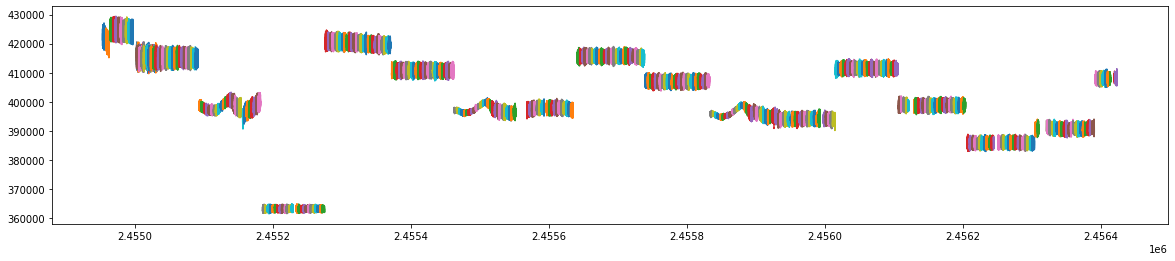

In [241]:
#all the data
fig = plt.figure(figsize=(20, 4))
for key in data.keys():
    plt.plot(data[key]['bjds'], data[key]['pdcsap_fluxes'])
plt.show()

In [242]:
def gaussian(x, a, b, c):
    return (a/(c*(2*np.pi)**0.5))*np.exp(-0.5*((x - b)/c)**2)

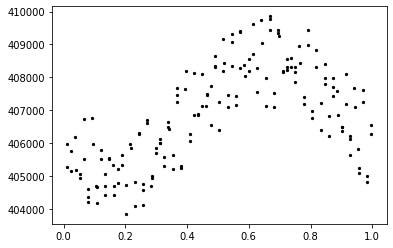

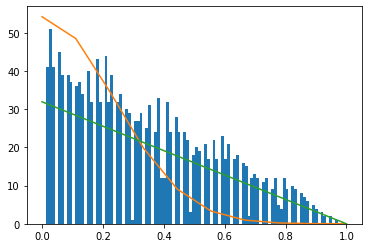

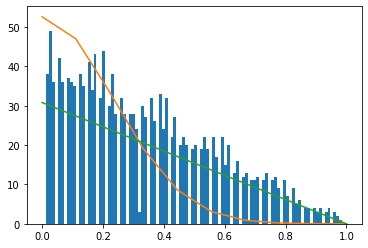

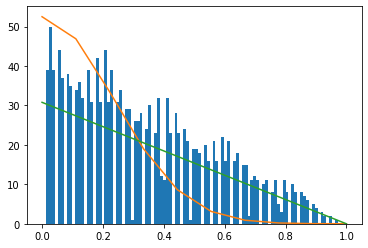

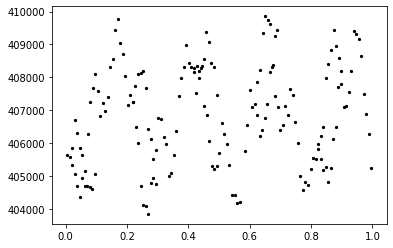

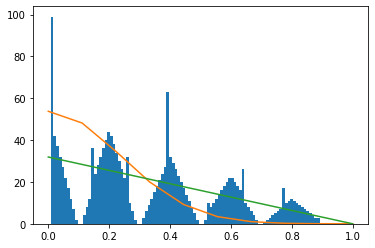

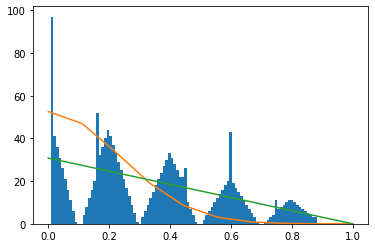

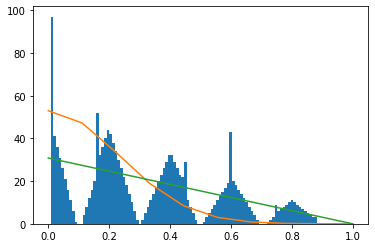

In [243]:
key = 500

tp = 0.009265 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
#times_sorted = [x for _, x in sorted(zip(folded_bjds, data[key]['bjds']))]
#fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

plt.scatter(folded_bjds, fixed_fluxes, c='k', s=5)
plt.show()

#bin the data
n_time_bins = 3
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

i = 0
binned_dists = []
while i < n_time_bins:
    binned_dists.append([])
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    for fbi in folded_bjds[indx]:
        for fbj in folded_bjds[indx]:
            if fbi > fbj:
                binned_dists[i].append(fbi - fbj)
    i += 1
    
for i in range(len(binned_dists)):
    n_bins = 100
    plt.hist(binned_dists[i], bins=n_bins)
    c = np.std(binned_dists[i])
    a = 2*len(binned_dists[i])/n_bins
    x = np.linspace(0, 1, 10)
    plt.plot(x, gaussian(x, a, 0, c))
    plt.plot([0, 1], [a, 0])
    plt.show()

tp = 0.009295 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
#times_sorted = [x for _, x in sorted(zip(folded_bjds, data[key]['bjds']))]
#fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

plt.scatter(folded_bjds, fixed_fluxes, c='k', s=5)
plt.show()

#bin the data
n_time_bins = 3
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

i = 0
binned_dists = []
while i < n_time_bins:
    binned_dists.append([])
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    for fbi in folded_bjds[indx]:
        for fbj in folded_bjds[indx]:
            if fbi > fbj:
                binned_dists[i].append(fbi - fbj)
    i += 1
    
for i in range(len(binned_dists)):
    n_bins = 100
    plt.hist(binned_dists[i], bins=n_bins)
    c = np.std(binned_dists[i])
    a = 2*len(binned_dists[i])/n_bins
    x = np.linspace(0, 1, 10)
    plt.plot(x, gaussian(x, a, 0, c))
    plt.plot([0, 1], [a, 0])
    plt.show()


In [244]:
from astropy.stats import RipleysKEstimator

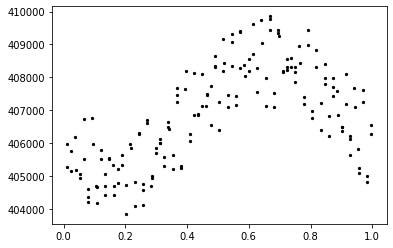

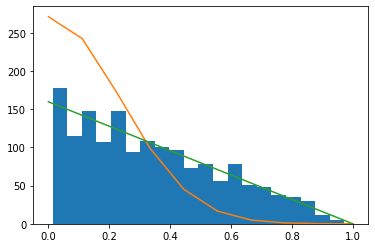

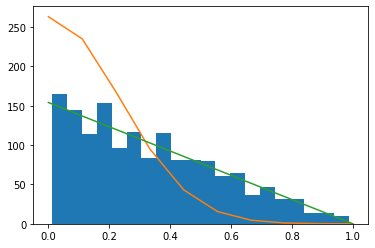

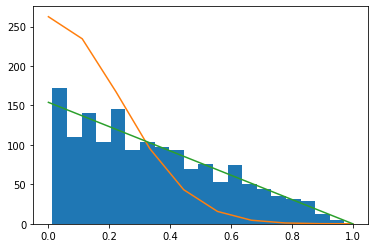

10814.020778249127


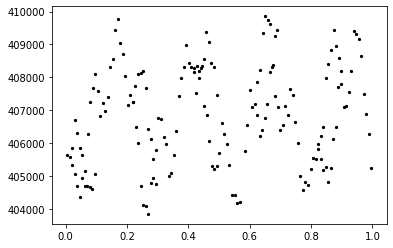

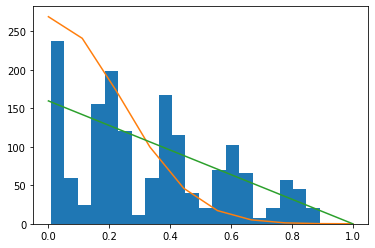

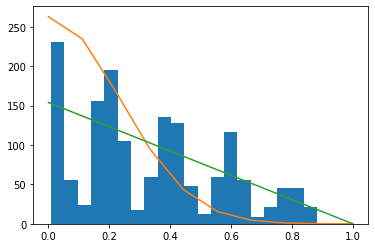

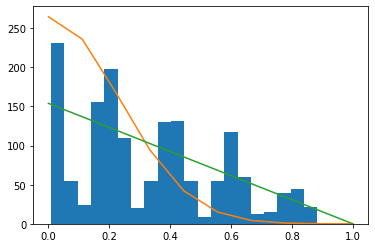

185955.8729985416


In [245]:
key = 500

tp = 0.009265 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
#times_sorted = [x for _, x in sorted(zip(folded_bjds, data[key]['bjds']))]
#fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

plt.scatter(folded_bjds, fixed_fluxes, c='k', s=5)
plt.show()

#bin the data
n_time_bins = 3
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

i = 0
binned_dists = []
while i < n_time_bins:
    binned_dists.append([])
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    for fbi in folded_bjds[indx]:
        for fbj in folded_bjds[indx]:
            if fbi > fbj:
                binned_dists[i].append(fbi - fbj)
    i += 1
    
stat = 0
for i in range(len(binned_dists)):
    n_bins = 20
    h, bins, patches = plt.hist(binned_dists[i], bins=n_bins)
    c = np.std(binned_dists[i])
    a = 2*len(binned_dists[i])/n_bins
    x = np.linspace(0, 1, 10)
    plt.plot(x, gaussian(x, a, 0, c))
    plt.plot([0, 1], [a, 0]) #y = a(1-x) = -ax + a
    plt.show()
    
    bin_midpoints = (bins[1:] + bins[:-1])/2
    y = a*(1 - bin_midpoints)
    stat += np.sum((h - y)**2)
    
print(stat)

tp = 0.009295 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
#times_sorted = [x for _, x in sorted(zip(folded_bjds, data[key]['bjds']))]
#fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

plt.scatter(folded_bjds, fixed_fluxes, c='k', s=5)
plt.show()

#bin the data
n_time_bins = 3
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

i = 0
binned_dists = []
while i < n_time_bins:
    binned_dists.append([])
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    for fbi in folded_bjds[indx]:
        for fbj in folded_bjds[indx]:
            if fbi > fbj:
                binned_dists[i].append(fbi - fbj)
    i += 1
    
for i in range(len(binned_dists)):
    n_bins = 20
    h, bins, patches = plt.hist(binned_dists[i], bins=n_bins)
    c = np.std(binned_dists[i])
    a = 2*len(binned_dists[i])/n_bins
    x = np.linspace(0, 1, 10)
    plt.plot(x, gaussian(x, a, 0, c))
    plt.plot([0, 1], [a, 0]) #y = a(1-x) = -ax + a
    plt.show()
    
    bin_midpoints = (bins[1:] + bins[:-1])/2
    y = a*(1 - bin_midpoints)
    stat += np.sum((h - y)**2)
    
print(stat)


In [305]:
def ripley_k(arr, tmin, tmax, nt=100, area=None):
    
    #build the distance matrix
    dists = np.zeros((len(arr), len(arr))) #will end up 0 for i <= j
    for i, eli in enumerate(arr):
        for j, elj in enumerate(arr):
            if i > j: #only calculate once
                d = abs(eli - elj)
                if d > 0.5:
                    d = 1 - d #'wrap-around' distance
                dists[i][j] = d
                dists[j][i] = d
    
    #compute number of values below/= diagonal in array
    low_diag_n = 0
    for i in range(len(arr)):
        low_diag_n += i+1
        
    #compute the k function
    s_list = [] #s(t)
    for t in np.linspace(tmin, tmax, nt):
        if t == 0:
            s = 0
        else:
            s = (np.sum((dists < t).astype(int)) - len(arr))
            #subtract len(arr) for the diagonals (which are always 0)
#         s = 0
#         for i, eli in enumerate(arr):
#             for j, elj in enumerate(arr):
#                 if (dists[i][j] > t) or (dists[j][i] > t):
#                     s += 1
        s_list.append(s)
       
    if not(area is None): #estimate area based on available data
        area = np.max(arr) - np.min(arr)
        
    return area*np.array(s_list)/(len(arr)*(len(arr)-1))

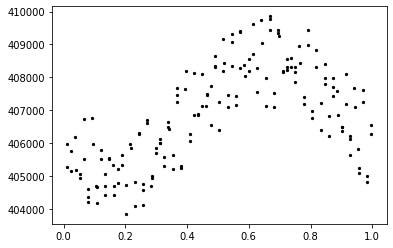

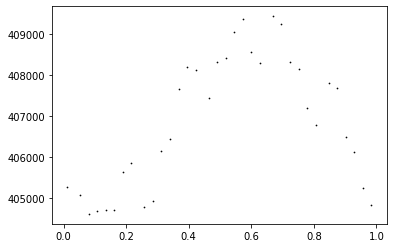

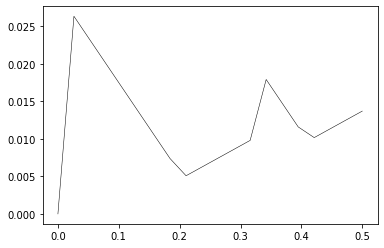

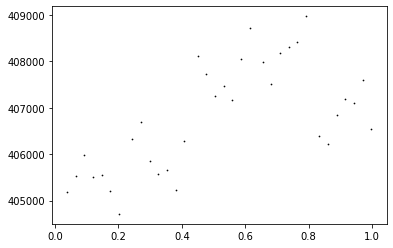

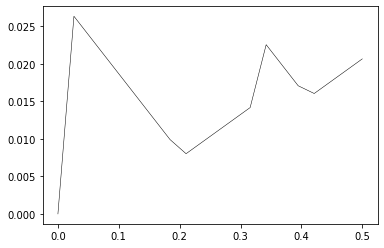

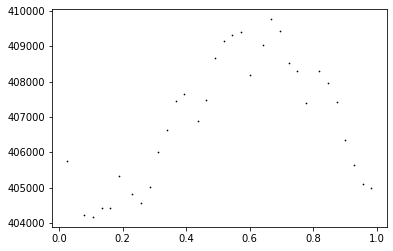

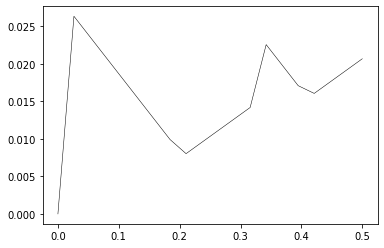

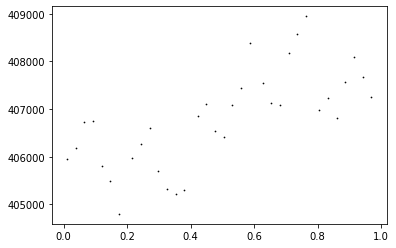

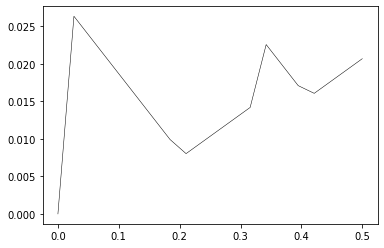

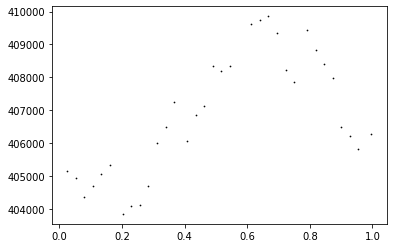

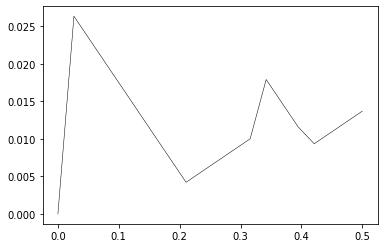

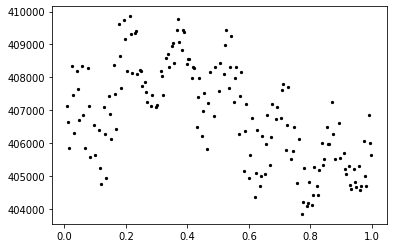

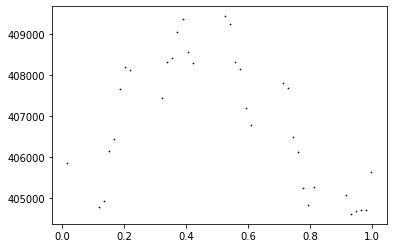

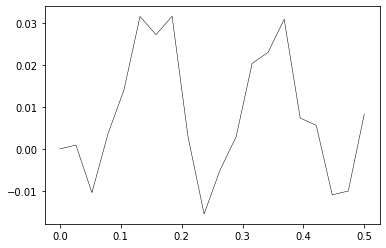

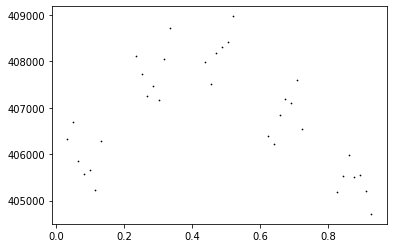

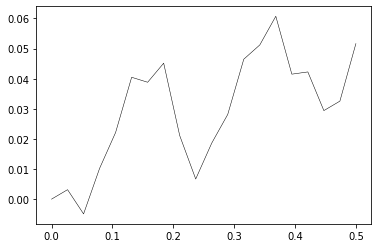

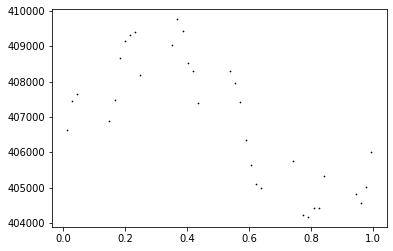

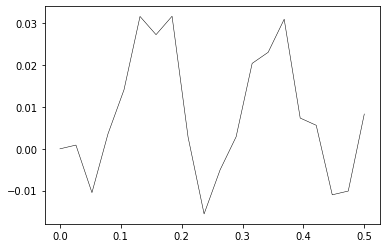

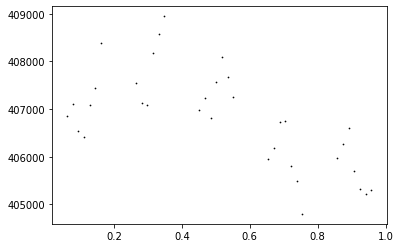

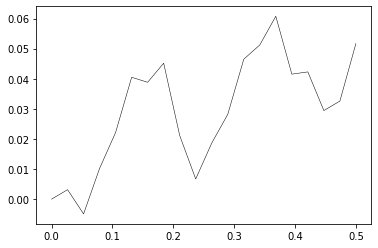

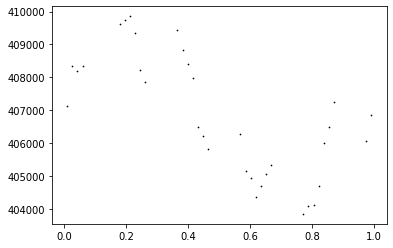

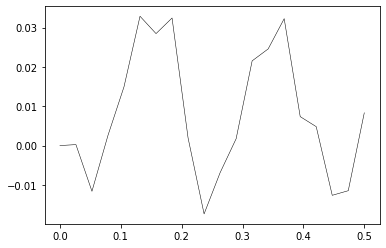

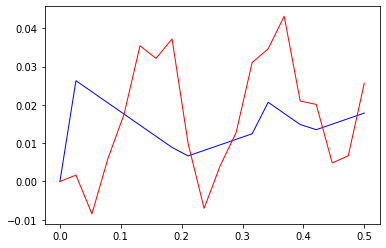

In [344]:
key = 500

tp = 0.009265 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
#times_sorted = [x for _, x in sorted(zip(folded_bjds, data[key]['bjds']))]
#fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

plt.scatter(folded_bjds, fixed_fluxes, c='k', s=5)
plt.show()

#bin the data
n_time_bins = 5
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

binned_fluxes = []
t = np.linspace(0, 0.5, 20)
mean_kt = np.zeros(len(t))
for i in range(n_time_bins):
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    binned_fluxes.append([folded_bjds[indx]])
    plt.scatter(folded_bjds[indx], fixed_fluxes[indx], c='k', s=0.5)
    plt.show()
    kt = ripley_k(folded_bjds[indx], 0, 0.5, nt=20, area=1)
    mean_kt += kt
    plt.plot(t, t - kt/2, c='k', lw=0.5)
    plt.show()
    
mean_kt1 = mean_kt / n_time_bins

#tp = 0.009295 #period guess for this particular star
tp = 0.009274 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
#times_sorted = [x for _, x in sorted(zip(folded_bjds, data[key]['bjds']))]
#fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

plt.scatter(folded_bjds, fixed_fluxes, c='k', s=5)
plt.show()

#bin the data
n_time_bins = 5
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

binned_fluxes = []
t = np.linspace(0, 0.5, 20)
mean_kt = np.zeros(len(t))
for i in range(n_time_bins):
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    binned_fluxes.append([folded_bjds[indx]])
    plt.scatter(folded_bjds[indx], fixed_fluxes[indx], c='k', s=0.5)
    plt.show()
    kt = ripley_k(folded_bjds[indx], 0, 0.5, nt=20, area=1)
    mean_kt += kt
    plt.plot(t, t - kt/2, c='k', lw=0.5)
    plt.show()

mean_kt2 = mean_kt / n_time_bins

plt.plot(t, t - mean_kt1/2, c='b', lw=1)
plt.plot(t, t - mean_kt2/2, c='r', lw=1)
plt.show()
    

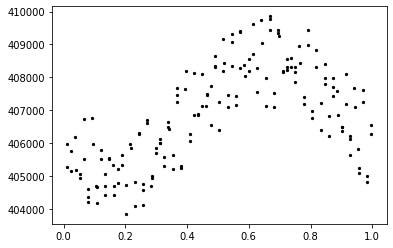

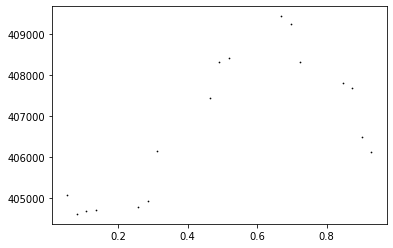

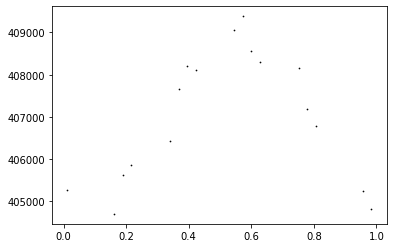

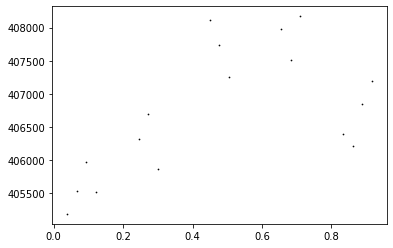

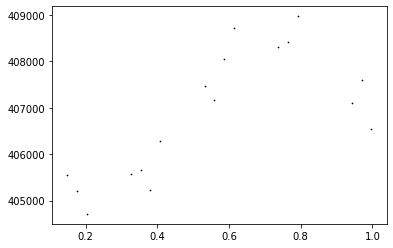

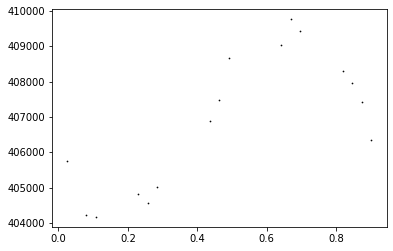

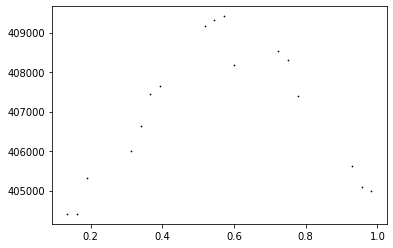

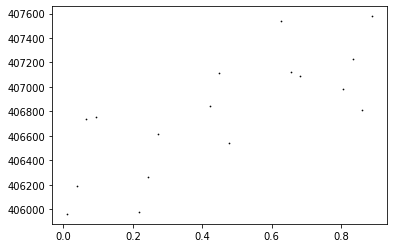

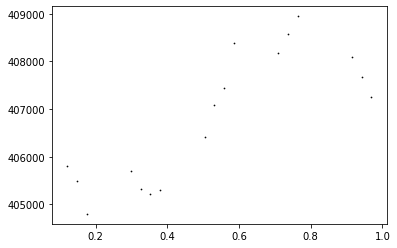

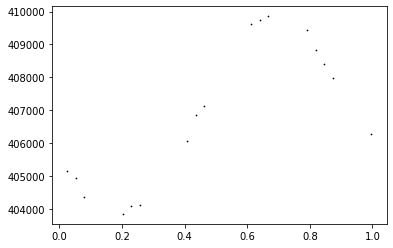

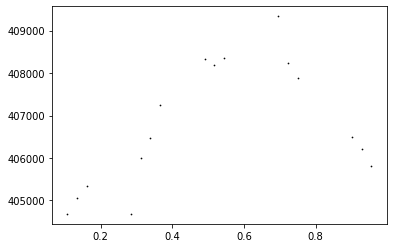

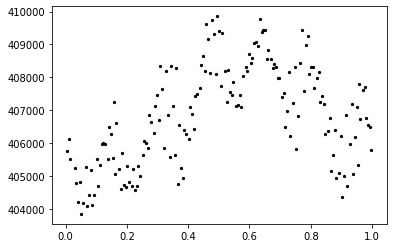

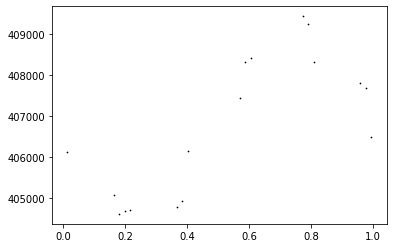

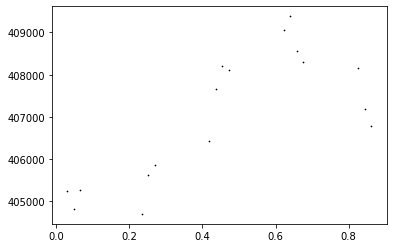

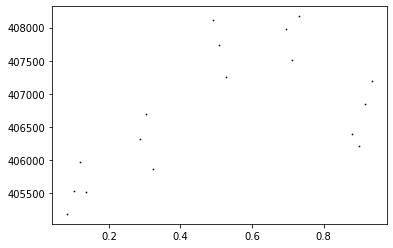

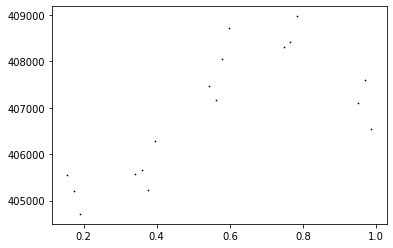

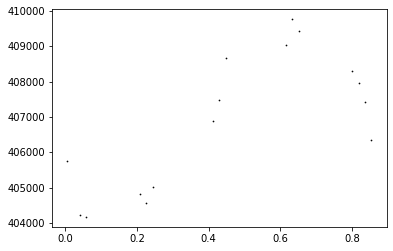

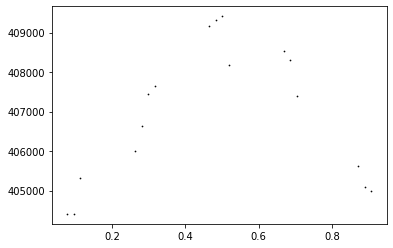

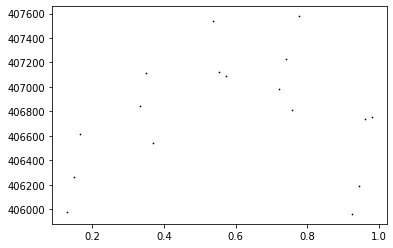

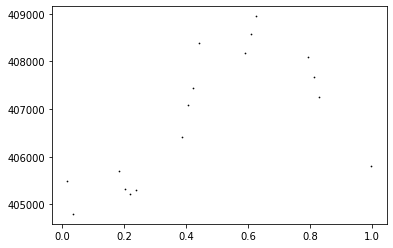

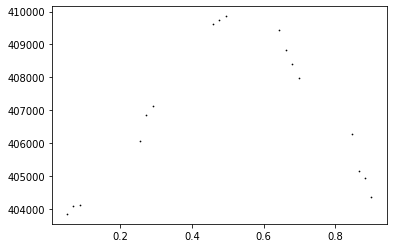

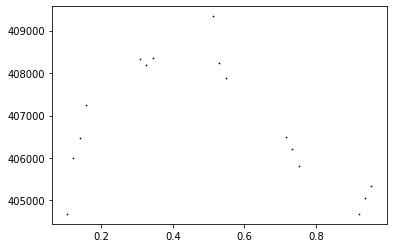

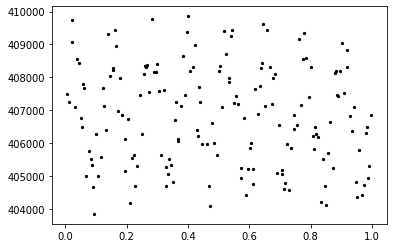

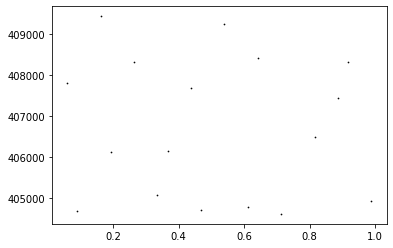

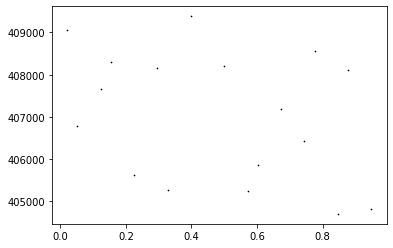

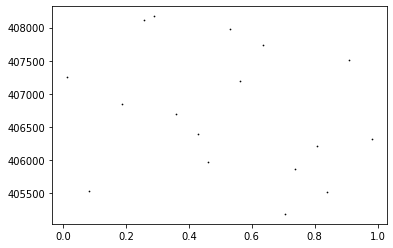

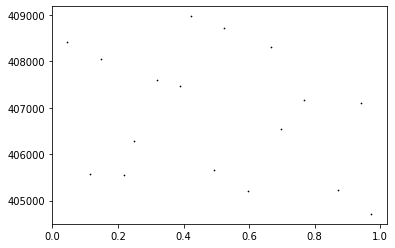

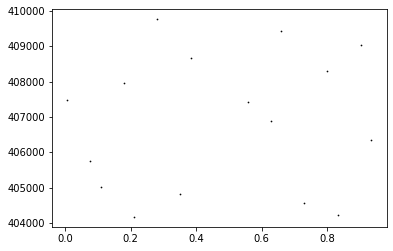

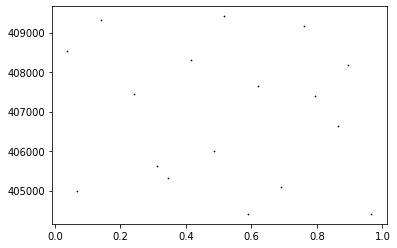

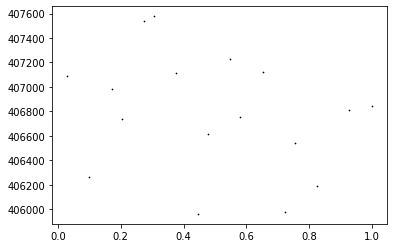

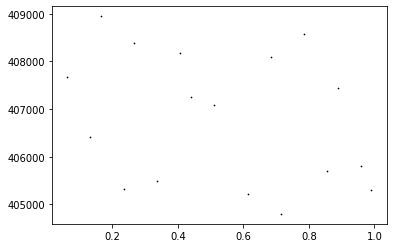

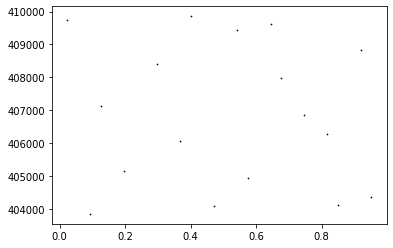

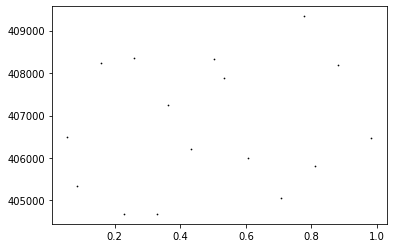

In [357]:
key = 500

tp = 0.009265 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
#times_sorted = [x for _, x in sorted(zip(folded_bjds, data[key]['bjds']))]
#fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

plt.scatter(folded_bjds, fixed_fluxes, c='k', s=5)
plt.show()

#bin the data
n_time_bins = 10
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

binned_fluxes = []
for i in range(n_time_bins):
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    binned_fluxes.append([folded_bjds[indx]])
    plt.scatter(folded_bjds[indx], fixed_fluxes[indx], c='k', s=0.5)
    plt.show()

#tp = 0.009295 #period guess for this particular star
tp = 0.009273 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
#times_sorted = [x for _, x in sorted(zip(folded_bjds, data[key]['bjds']))]
#fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

plt.scatter(folded_bjds, fixed_fluxes, c='k', s=5)
plt.show()

#bin the data
n_time_bins = 10
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

binned_fluxes = []
for i in range(n_time_bins):
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    binned_fluxes.append([folded_bjds[indx]])
    plt.scatter(folded_bjds[indx], fixed_fluxes[indx], c='k', s=0.5)
    plt.show()
    
    
#tp = 0.009295 #period guess for this particular star
tp = 0.07414 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
#times_sorted = [x for _, x in sorted(zip(folded_bjds, data[key]['bjds']))]
#fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

plt.scatter(folded_bjds, fixed_fluxes, c='k', s=5)
plt.show()

#bin the data
n_time_bins = 10
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

binned_fluxes = []
for i in range(n_time_bins):
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    binned_fluxes.append([folded_bjds[indx]])
    plt.scatter(folded_bjds[indx], fixed_fluxes[indx], c='k', s=0.5)
    plt.show()
    

In [358]:
#Probably want to use fundamental freq as per fft,
#then determine how many peaks are in folded light curve
#then divide period by that number and try again
#no clue how well this will work but I think we have to do something like this

In [342]:
def kld(arr):
    h = np.histogram(arr, bins=50)[0]
    kld = h * np.log(h/np.mean(h))
    return np.nansum(kld)

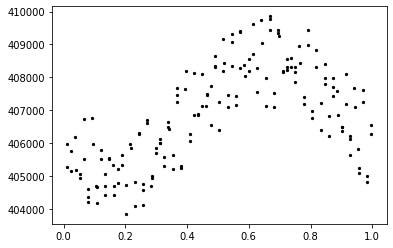

18.33976424332281
18.339764243322808
18.33976424332281
18.33976424332281
18.33976424332281
18.33976424332281
18.33976424332281
18.33976424332281
18.339764243322808
18.230948531013837


/tmp/ipykernel_8890/1995085703.py:3: RuntimeWarning: divide by zero encountered in log
  kld = h * np.log(h/np.mean(h))
/tmp/ipykernel_8890/1995085703.py:3: RuntimeWarning: invalid value encountered in multiply
  kld = h * np.log(h/np.mean(h))


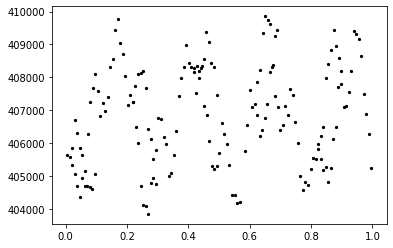

37.72602477417471
38.772521061703806
36.86297855681937
36.86297855681937
36.939215716182325


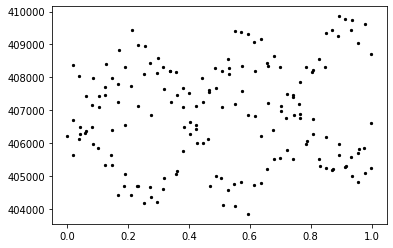

13.112524347607474
13.112524347607474
13.112524347607474
13.112524347607474
13.712009650734974


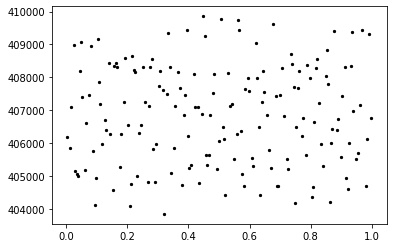

21.430290514326817
15.885113069847254
15.885113069847254
17.271407430967145
17.870892734094642


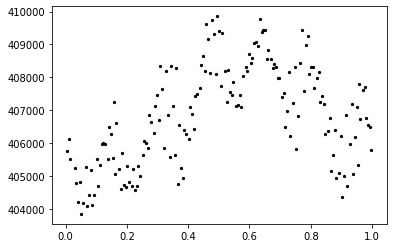

19.7260586044427
18.33976424332281
18.339764243322808
18.33976424332281
18.339764243322808
18.33976424332281
18.339764243322808
19.7260586044427
18.339764243322808
18.230948531013837


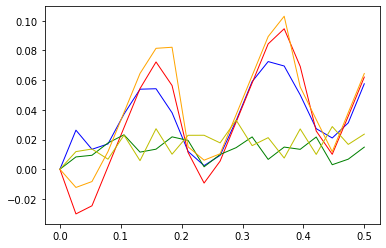

In [352]:
key = 500

tp = 0.009265 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
#times_sorted = [x for _, x in sorted(zip(folded_bjds, data[key]['bjds']))]
#fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

plt.scatter(folded_bjds, fixed_fluxes, c='k', s=5)
plt.show()

#bin the data
n_time_bins = 10
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

binned_fluxes = []
t = np.linspace(0, 0.5, 20)
mean_kt = np.zeros(len(t))
for i in range(n_time_bins):
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    binned_fluxes.append([folded_bjds[indx]])
    print(kld(folded_bjds[indx]))
    kt = ripley_k(folded_bjds[indx], 0, 0.5, nt=20, area=1)
    mean_kt += kt
    
mean_kt1 = mean_kt / n_time_bins

tp = 0.009295 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
#times_sorted = [x for _, x in sorted(zip(folded_bjds, data[key]['bjds']))]
#fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

plt.scatter(folded_bjds, fixed_fluxes, c='k', s=5)
plt.show()

#bin the data
n_time_bins = 5
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

binned_fluxes = []
t = np.linspace(0, 0.5, 20)
mean_kt = np.zeros(len(t))
for i in range(n_time_bins):
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    binned_fluxes.append([folded_bjds[indx]])
    print(kld(folded_bjds[indx]))
    kt = ripley_k(folded_bjds[indx], 0, 0.5, nt=20, area=1)
    mean_kt += kt

mean_kt2 = mean_kt / n_time_bins



tp = 0.009324 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
#times_sorted = [x for _, x in sorted(zip(folded_bjds, data[key]['bjds']))]
#fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

plt.scatter(folded_bjds, fixed_fluxes, c='k', s=5)
plt.show()

#bin the data
n_time_bins = 5
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

binned_fluxes = []
t = np.linspace(0, 0.5, 20)
mean_kt = np.zeros(len(t))
for i in range(n_time_bins):
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    binned_fluxes.append([folded_bjds[indx]])
    print(kld(folded_bjds[indx]))
    kt = ripley_k(folded_bjds[indx], 0, 0.5, nt=20, area=1)
    mean_kt += kt

mean_kt3 = mean_kt / n_time_bins



tp = 0.009385 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
#times_sorted = [x for _, x in sorted(zip(folded_bjds, data[key]['bjds']))]
#fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

plt.scatter(folded_bjds, fixed_fluxes, c='k', s=5)
plt.show()

#bin the data
n_time_bins = 5
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

binned_fluxes = []
t = np.linspace(0, 0.5, 20)
mean_kt = np.zeros(len(t))
for i in range(n_time_bins):
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    binned_fluxes.append([folded_bjds[indx]])
    print(kld(folded_bjds[indx]))
    kt = ripley_k(folded_bjds[indx], 0, 0.5, nt=20, area=1)
    mean_kt += kt

mean_kt4 = mean_kt / n_time_bins




tp = 0.009273 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
#times_sorted = [x for _, x in sorted(zip(folded_bjds, data[key]['bjds']))]
#fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

plt.scatter(folded_bjds, fixed_fluxes, c='k', s=5)
plt.show()

#bin the data
n_time_bins = 10
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

binned_fluxes = []
t = np.linspace(0, 0.5, 20)
mean_kt = np.zeros(len(t))
for i in range(n_time_bins):
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    binned_fluxes.append([folded_bjds[indx]])
    print(kld(folded_bjds[indx]))
    kt = ripley_k(folded_bjds[indx], 0, 0.5, nt=20, area=1)
    mean_kt += kt

mean_kt5 = mean_kt / n_time_bins



plt.plot(t, t - mean_kt1/2, c='b', lw=1)
plt.plot(t, t - mean_kt2/2, c='r', lw=1)
plt.plot(t, t - mean_kt3/2, c='g', lw=1)
plt.plot(t, t - mean_kt4/2, c='y', lw=1)
plt.plot(t, t - mean_kt5/2, c='orange', lw=1)
plt.show()
    

In [246]:
from scipy.signal import correlate, correlation_lags

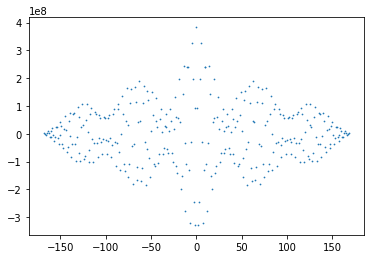

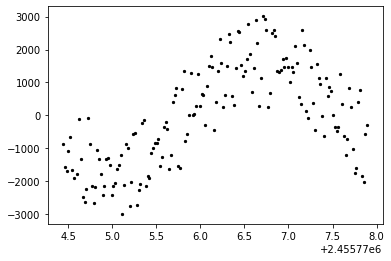

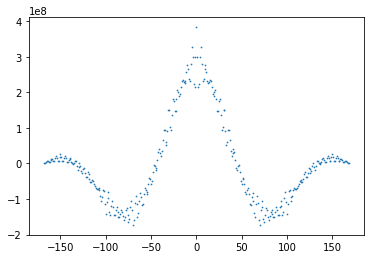

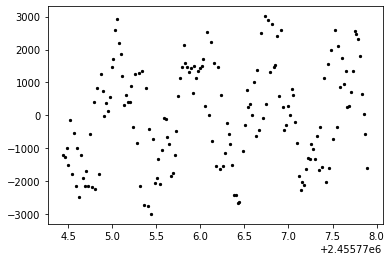

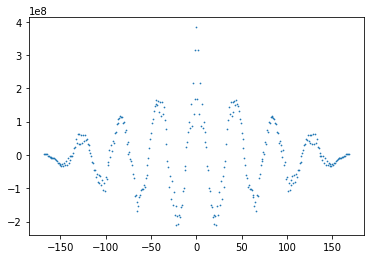

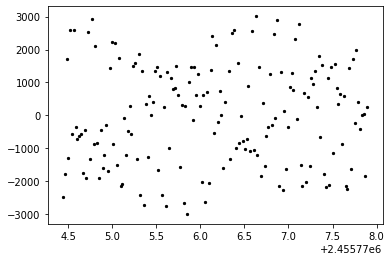

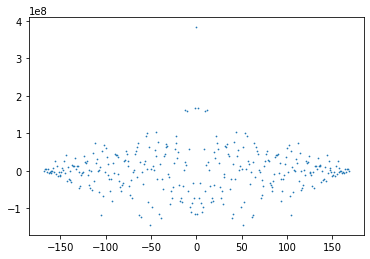

In [247]:
key = 500

tp = 0.009265 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes'] - np.nanmean(data[key]['pdcsap_fluxes'])
indx = np.logical_not(np.isnan(fixed_fluxes))

c = correlate(fixed_fluxes[indx], fixed_fluxes[indx], method='direct')
c_lags = correlation_lags(len(fixed_fluxes[indx]), len(fixed_fluxes[indx]))
plt.scatter(c_lags, c, s=0.5)
plt.show()

fixed_fluxes_sorted = np.array([x for _, x in sorted(zip(folded_bjds, fixed_fluxes))])
indx = np.logical_not(np.isnan(fixed_fluxes_sorted))

plt.scatter(np.array(data[key]['bjds'])[indx], fixed_fluxes_sorted[indx], c='k', s=5)
plt.show()

c = correlate(fixed_fluxes_sorted[indx], fixed_fluxes_sorted[indx], method='direct')
c_lags = correlation_lags(len(fixed_fluxes_sorted[indx]), len(fixed_fluxes_sorted[indx]))
plt.scatter(c_lags, c, s=0.5)
plt.show()

tp = 0.009295 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes'] - np.nanmean(data[key]['pdcsap_fluxes'])
fixed_fluxes_sorted = np.array([x for _, x in sorted(zip(folded_bjds, fixed_fluxes))])
indx = np.logical_not(np.isnan(fixed_fluxes_sorted))

plt.scatter(np.array(data[key]['bjds'])[indx], fixed_fluxes_sorted[indx], c='k', s=5)
plt.show()

c = correlate(fixed_fluxes_sorted[indx], fixed_fluxes_sorted[indx], method='direct')
c_lags = correlation_lags(len(fixed_fluxes_sorted[indx]), len(fixed_fluxes_sorted[indx]))
plt.scatter(c_lags, c, s=0.5)
plt.show()



tp = 0.009350 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes'] - np.nanmean(data[key]['pdcsap_fluxes'])
fixed_fluxes_sorted = np.array([x for _, x in sorted(zip(folded_bjds, fixed_fluxes))])
indx = np.logical_not(np.isnan(fixed_fluxes_sorted))

plt.scatter(np.array(data[key]['bjds'])[indx], fixed_fluxes_sorted[indx], c='k', s=5)
plt.show()

c = correlate(fixed_fluxes_sorted[indx], fixed_fluxes_sorted[indx], method='direct')
c_lags = correlation_lags(len(fixed_fluxes_sorted[indx]), len(fixed_fluxes_sorted[indx]))
plt.scatter(c_lags, c, s=0.5)
plt.show()


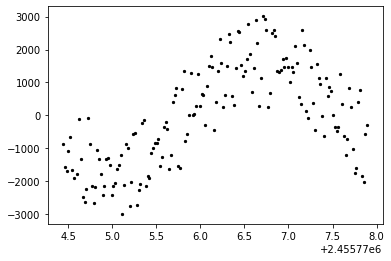

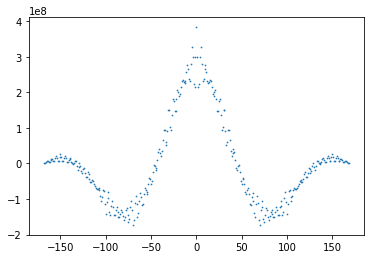

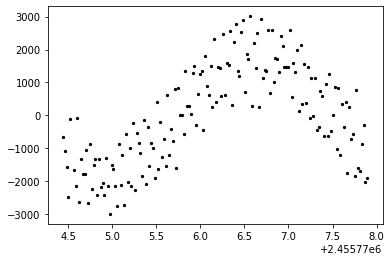

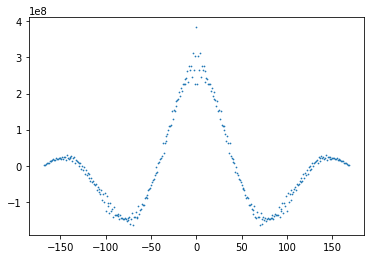

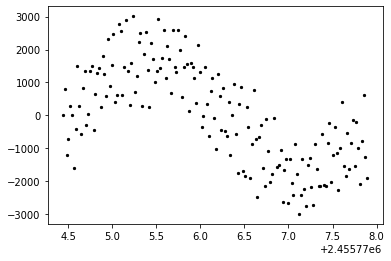

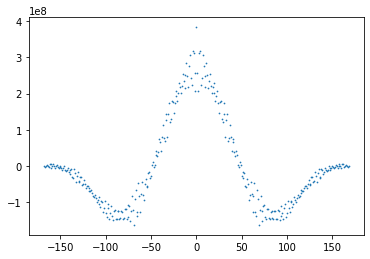

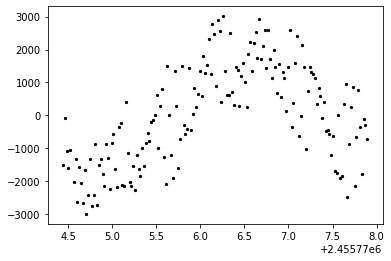

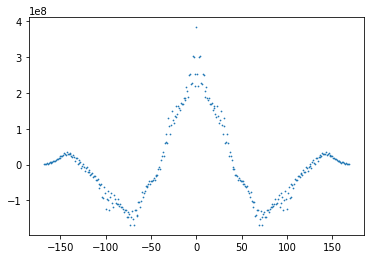

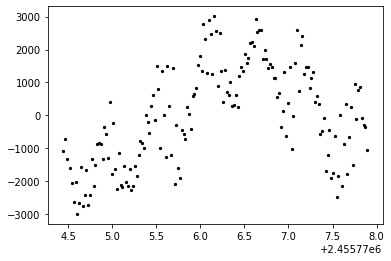

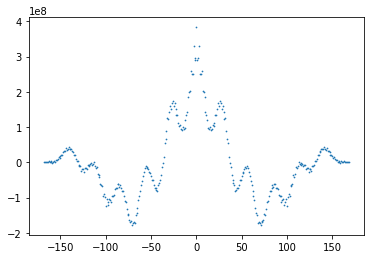

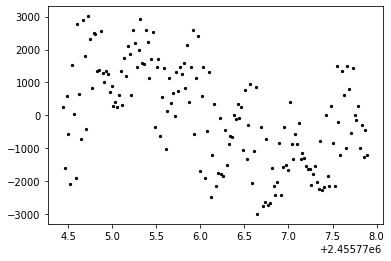

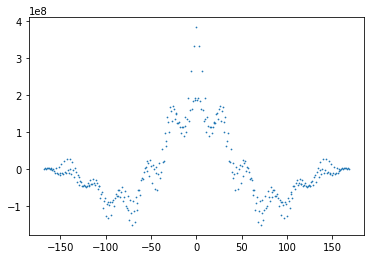

In [248]:
key = 500

tp = 0.009265 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes'] - np.nanmean(data[key]['pdcsap_fluxes'])
indx = np.logical_not(np.isnan(fixed_fluxes))

fixed_fluxes_sorted = np.array([x for _, x in sorted(zip(folded_bjds, fixed_fluxes))])
indx = np.logical_not(np.isnan(fixed_fluxes_sorted))

plt.scatter(np.array(data[key]['bjds'])[indx], fixed_fluxes_sorted[indx], c='k', s=5)
plt.show()

c = correlate(fixed_fluxes_sorted[indx], fixed_fluxes_sorted[indx], method='direct')
c_lags = correlation_lags(len(fixed_fluxes_sorted[indx]), len(fixed_fluxes_sorted[indx]))
plt.scatter(c_lags, c, s=0.5)
plt.show()



tp = 0.009267 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes'] - np.nanmean(data[key]['pdcsap_fluxes'])
indx = np.logical_not(np.isnan(fixed_fluxes))

fixed_fluxes_sorted = np.array([x for _, x in sorted(zip(folded_bjds, fixed_fluxes))])
indx = np.logical_not(np.isnan(fixed_fluxes_sorted))

plt.scatter(np.array(data[key]['bjds'])[indx], fixed_fluxes_sorted[indx], c='k', s=5)
plt.show()

c = correlate(fixed_fluxes_sorted[indx], fixed_fluxes_sorted[indx], method='direct')
c_lags = correlation_lags(len(fixed_fluxes_sorted[indx]), len(fixed_fluxes_sorted[indx]))
plt.scatter(c_lags, c, s=0.5)
plt.show()


tp = 0.009269 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes'] - np.nanmean(data[key]['pdcsap_fluxes'])
indx = np.logical_not(np.isnan(fixed_fluxes))

fixed_fluxes_sorted = np.array([x for _, x in sorted(zip(folded_bjds, fixed_fluxes))])
indx = np.logical_not(np.isnan(fixed_fluxes_sorted))

plt.scatter(np.array(data[key]['bjds'])[indx], fixed_fluxes_sorted[indx], c='k', s=5)
plt.show()

c = correlate(fixed_fluxes_sorted[indx], fixed_fluxes_sorted[indx], method='direct')
c_lags = correlation_lags(len(fixed_fluxes_sorted[indx]), len(fixed_fluxes_sorted[indx]))
plt.scatter(c_lags, c, s=0.5)
plt.show()


tp = 0.009271 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes'] - np.nanmean(data[key]['pdcsap_fluxes'])
indx = np.logical_not(np.isnan(fixed_fluxes))

fixed_fluxes_sorted = np.array([x for _, x in sorted(zip(folded_bjds, fixed_fluxes))])
indx = np.logical_not(np.isnan(fixed_fluxes_sorted))

plt.scatter(np.array(data[key]['bjds'])[indx], fixed_fluxes_sorted[indx], c='k', s=5)
plt.show()

c = correlate(fixed_fluxes_sorted[indx], fixed_fluxes_sorted[indx], method='direct')
c_lags = correlation_lags(len(fixed_fluxes_sorted[indx]), len(fixed_fluxes_sorted[indx]))
plt.scatter(c_lags, c, s=0.5)
plt.show()



tp = 0.009273 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes'] - np.nanmean(data[key]['pdcsap_fluxes'])
indx = np.logical_not(np.isnan(fixed_fluxes))

fixed_fluxes_sorted = np.array([x for _, x in sorted(zip(folded_bjds, fixed_fluxes))])
indx = np.logical_not(np.isnan(fixed_fluxes_sorted))

plt.scatter(np.array(data[key]['bjds'])[indx], fixed_fluxes_sorted[indx], c='k', s=5)
plt.show()

c = correlate(fixed_fluxes_sorted[indx], fixed_fluxes_sorted[indx], method='direct')
c_lags = correlation_lags(len(fixed_fluxes_sorted[indx]), len(fixed_fluxes_sorted[indx]))
plt.scatter(c_lags, c, s=0.5)
plt.show()



tp = 0.009275 #period guess for this particular star
folded_bjds = (data[key]['bjds']/tp) - (data[key]['bjds']/tp).astype(int)
fixed_fluxes = data[key]['pdcsap_fluxes'] - np.nanmean(data[key]['pdcsap_fluxes'])
indx = np.logical_not(np.isnan(fixed_fluxes))

fixed_fluxes_sorted = np.array([x for _, x in sorted(zip(folded_bjds, fixed_fluxes))])
indx = np.logical_not(np.isnan(fixed_fluxes_sorted))

plt.scatter(np.array(data[key]['bjds'])[indx], fixed_fluxes_sorted[indx], c='k', s=5)
plt.show()

c = correlate(fixed_fluxes_sorted[indx], fixed_fluxes_sorted[indx], method='direct')
c_lags = correlation_lags(len(fixed_fluxes_sorted[indx]), len(fixed_fluxes_sorted[indx]))
plt.scatter(c_lags, c, s=0.5)
plt.show()